In this simple exploration notebook, let us try and explore the dataset given for this competition.

**Objective:**

To classify whether question pairs are duplicate or not. 

Let us start with importing the necessary modules for exploring the data.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams 
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost as xgb

eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

Let us read both the train and test dataset and check the number of rows.

In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
print(train_df.shape)
print(test_df.shape)

(404290, 6)
(2345796, 3)


Okay. So there are about 400K rows in train set and about 2.35M rows in test set.

Also there are 6 columns in train set but only 3 of them are in test set. So we shall first look at the top few lines to understand the columns that are missing in the test set.

In [4]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


**Data fields**

id - the id of a training set question pair

qid1, qid2 - unique ids of each question (only available in train.csv)

question1, question2 - the full text of each question

is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [5]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


So we do not have question ids for the test set. I hope the reason is as follows:

*As an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora.*

Since some questions are not from Quora, question ids are not present I think.

**Target Variable Exploration:**

First let us look at the target variable distribution.

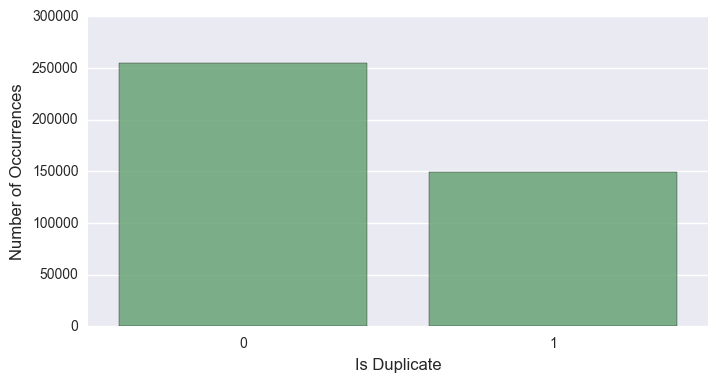

In [6]:
is_dup = train_df['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [7]:
is_dup / is_dup.sum()

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

**Questions Exploration:**

Now let us explore the question fields present in the train data. First let us check the number of words distribution in the questions.

In [8]:
all_ques_df = pd.DataFrame(pd.concat([train_df['question1'], train_df['question2']]))
all_ques_df.columns = ["questions"]

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

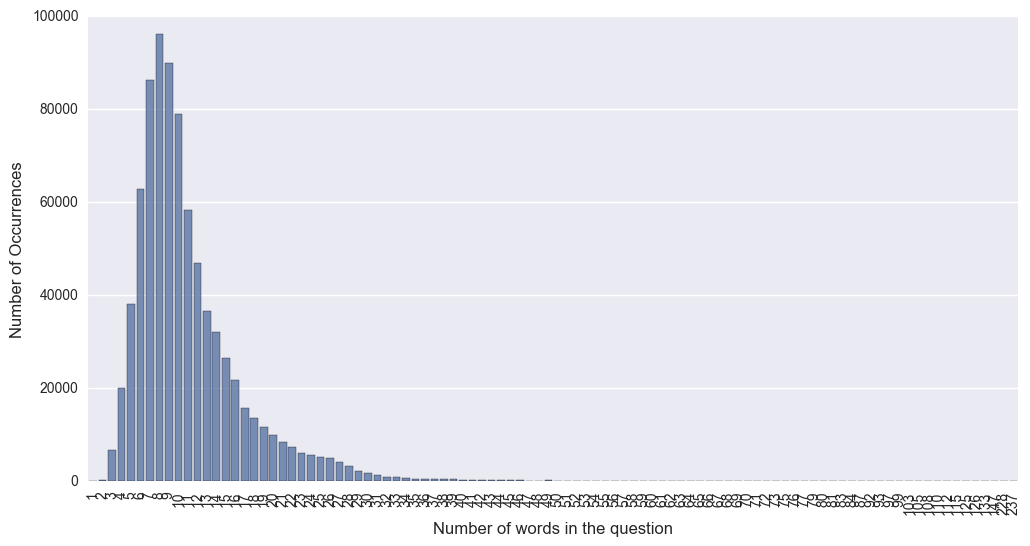

In [9]:
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So we have about 63% non-duplicate questions and 37% duplicate questions in the training data set.

So the distribution is right skewed with upto 237 words in a question. There are also few questions with 1 or 2 words as well.

Now let us explore the number of characters distribution as well.

In [9]:
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))
cnt_srs = all_ques_df['num_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()      

del all_ques_df

NameError: name 'all_ques_df' is not defined

Number of characters distribution as well is right skewed.

One interesting point is the sudden dip at the 150 character mark. Not sure why is that so.!

Now let us look at the distribution of common unigrams between the given question pairs.

In [10]:
eng_stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 'd',
 'did',
 'didn',
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 'has',
 'hasn',
 'have',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 'it',
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 'more',
 'most',
 'mustn',
 'my',
 'myself',
 'needn',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 'she',
 'should',
 'shouldn',
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 'the',
 'their',
 'theirs',
 'them',
 

In [12]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]#word_tokenize:对句子进行分词

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )#取交集

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

In [13]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, ind...","[step, step, guide, invest, share, market, ?]",6,0.857143
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, (, koh-i-noor, ), diamond, ?]","[would, happen, indian, government, stole, koh...",6,0.461538
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns, ?]",3,0.300000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, ?, solve, ?]","[find, remainder, [, math, ], 23^, {, 24, }, [...",1,0.062500
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, ,, salt,...","[fish, would, survive, salt, water, ?]",3,0.200000


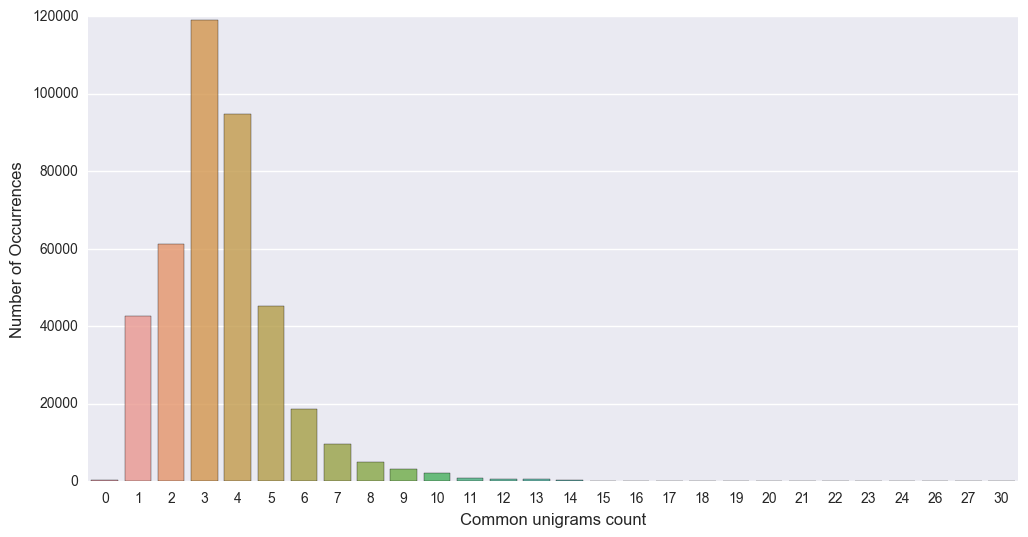

In [16]:
cnt_srs = train_df['unigrams_common_count'].value_counts()#q1与q2相同词统计

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count', fontsize=12)
plt.show()

It is interesting to see that there are very few question pairs with no common words. 

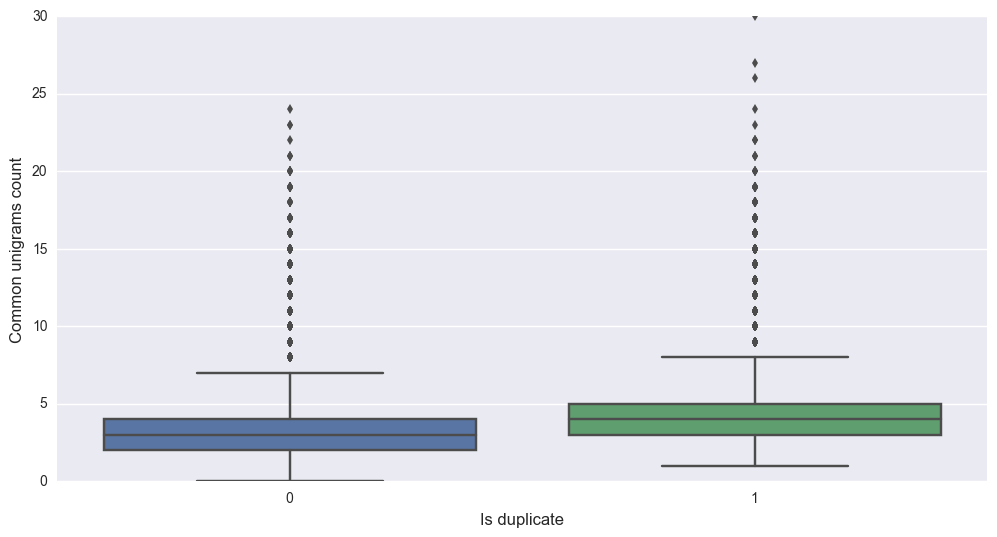

In [17]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_count", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams count', fontsize=12)
plt.show()

There is some good difference between 0 and 1 class using the common unigram count variable. Let us look at the same graph using common unigrams ratio.

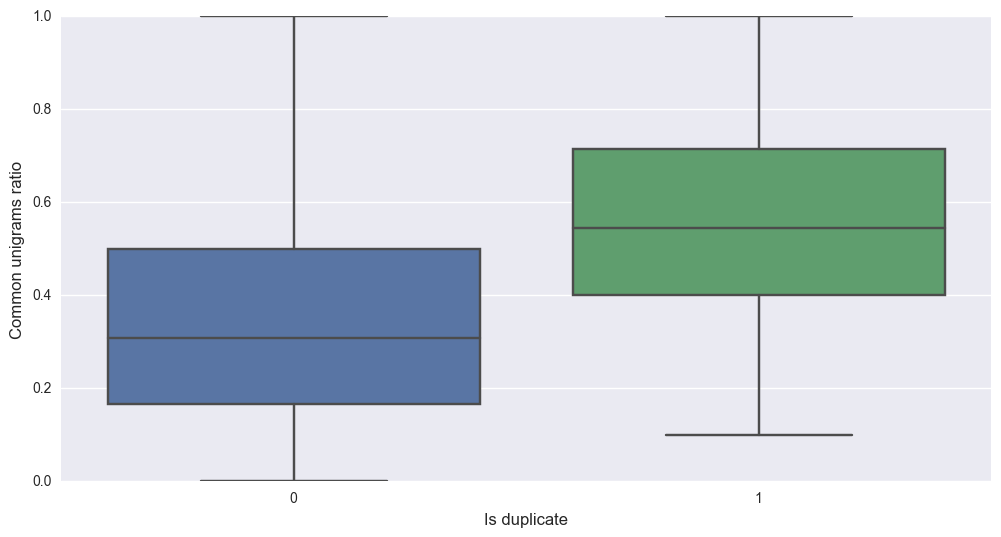

In [18]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_ratio", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams ratio', fontsize=12)
plt.show()

Now let us do the same analysis using bigrams.

**BIgrams:**

In [19]:
def get_bigrams(que):
    return [i for i in ngrams(que, 2)]#组合分词

def get_common_bigrams(row):
    return len( set(row["bigrams_ques1"]).intersection(set(row["bigrams_ques2"])) )

def get_common_bigram_ratio(row):
    return float(row["bigrams_common_count"]) / max(len( set(row["bigrams_ques1"]).union(set(row["bigrams_ques2"])) ),1)

train_df["bigrams_ques1"] = train_df["unigrams_ques1"].apply(lambda x: get_bigrams(x))
train_df["bigrams_ques2"] = train_df["unigrams_ques2"].apply(lambda x: get_bigrams(x)) 
train_df["bigrams_common_count"] = train_df.apply(lambda row: get_common_bigrams(row),axis=1)
train_df["bigrams_common_ratio"] = train_df.apply(lambda row: get_common_bigram_ratio(row), axis=1)

In [20]:
train_df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio,bigrams_ques1,bigrams_ques2,bigrams_common_count,bigrams_common_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, ind...","[step, step, guide, invest, share, market, ?]",6,0.857143,"[(step, step), (step, guide), (guide, invest),...","[(step, step), (step, guide), (guide, invest),...",5,0.625000
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, (, koh-i-noor, ), diamond, ?]","[would, happen, indian, government, stole, koh...",6,0.461538,"[(story, kohinoor), (kohinoor, (), ((, koh-i-n...","[(would, happen), (happen, indian), (indian, g...",4,0.307692
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns, ?]",3,0.300000,"[(increase, speed), (speed, internet), (intern...","[(internet, speed), (speed, increased), (incre...",0,0.000000


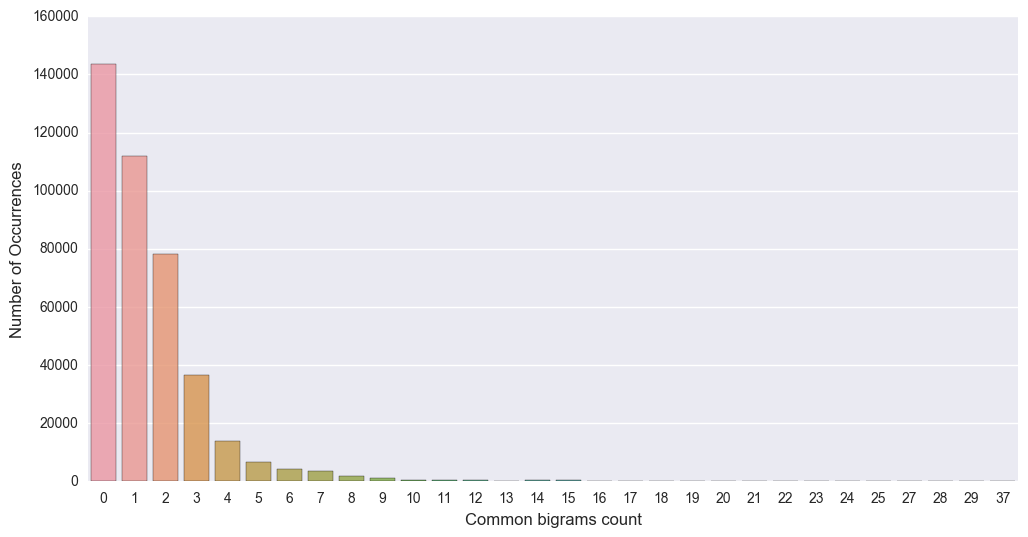

In [21]:
cnt_srs = train_df['bigrams_common_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common bigrams count', fontsize=12)
plt.show()

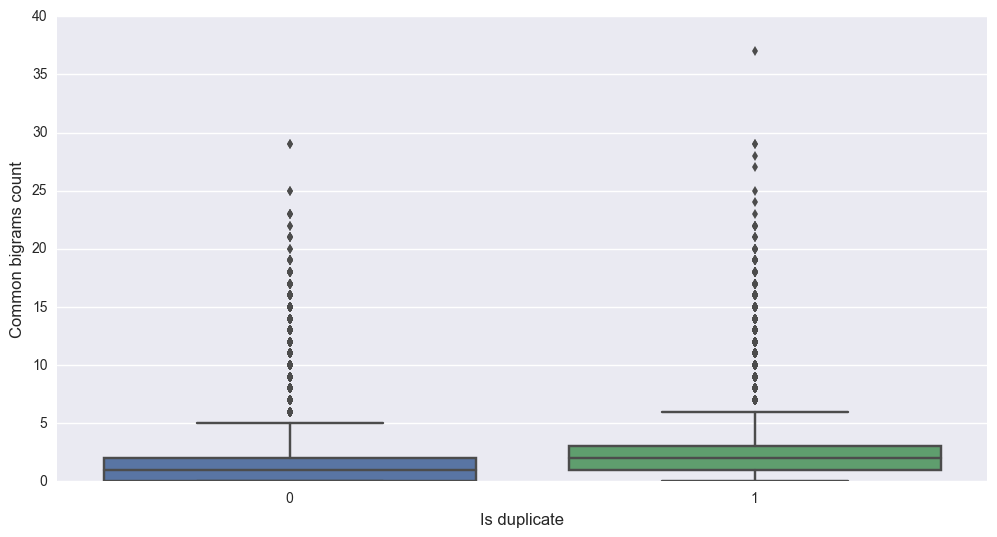

In [22]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="bigrams_common_count", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common bigrams count', fontsize=12)
plt.show()

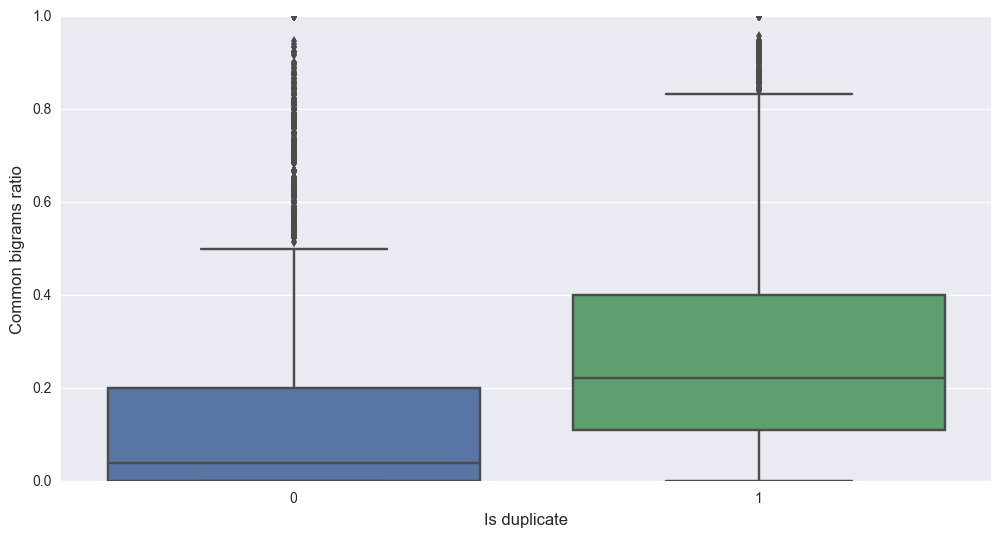

In [23]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="bigrams_common_ratio", data=train_df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common bigrams ratio', fontsize=12)
plt.show()

We could see a good class difference. So this ratio could be a good predictor between both classes.  

**Basic Model:**

We see that common unigrams and bigrams are good at differentiating the two classes. So we shall also include trigrams and build a XGB model on top of it.

In [ ]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]#word_tokenize:对句子进行分词

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )#取交集

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

In [18]:
def feature_extraction(row):
    que1 = str(row['question1'])
    que2 = str(row['question2'])
    out_list = []
    # get unigram features #
    unigrams_que1 = [word for word in word_tokenize(que1.lower()) if word not in eng_stopwords]
    unigrams_que2 = [word for word in word_tokenize(que2.lower()) if word not in eng_stopwords]
    #unigrams_que1 = [word for word in que1.lower().split() if word not in eng_stopwords]
    #unigrams_que2 = [word for word in que2.lower().split() if word not in eng_stopwords]
    common_unigrams_len = len(set(unigrams_que1).intersection(set(unigrams_que2)))
    common_unigrams_ratio = float(common_unigrams_len) / max(len(set(unigrams_que1).union(set(unigrams_que2))),1)
    out_list.extend([common_unigrams_len, common_unigrams_ratio])

    # get bigram features #
    bigrams_que1 = [i for i in ngrams(unigrams_que1, 2)]
    bigrams_que2 = [i for i in ngrams(unigrams_que2, 2)]
    common_bigrams_len = len(set(bigrams_que1).intersection(set(bigrams_que2)))
    common_bigrams_ratio = float(common_bigrams_len) / max(len(set(bigrams_que1).union(set(bigrams_que2))),1)
    out_list.extend([common_bigrams_len, common_bigrams_ratio])

    # get trigram features #
    trigrams_que1 = [i for i in ngrams(unigrams_que1, 3)]
    trigrams_que2 = [i for i in ngrams(unigrams_que2, 3)]
    common_trigrams_len = len(set(trigrams_que1).intersection(set(trigrams_que2)))
    common_trigrams_ratio = float(common_trigrams_len) / max(len(set(trigrams_que1).union(set(trigrams_que2))),1)
    out_list.extend([common_trigrams_len, common_trigrams_ratio])
    return out_list

In [19]:
train_X = np.vstack( np.array(train_df.apply(lambda row: feature_extraction(row), axis=1)) ) 
test_X = np.vstack( np.array(test_df.apply(lambda row: feature_extraction(row), axis=1)) )
train_y = np.array(train_df["is_duplicate"])

train_X

array([[ 6.        ,  0.85714286,  5.        ,  0.625     ,  4.        ,
         0.57142857],
       [ 6.        ,  0.46153846,  4.        ,  0.30769231,  3.        ,
         0.25      ],
       [ 3.        ,  0.3       ,  0.        ,  0.        ,  0.        ,
         0.        ],
       ..., 
       [ 2.        ,  0.5       ,  1.        ,  0.33333333,  0.        ,
         0.        ],
       [ 2.        ,  0.08      ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 4.        ,  1.        ,  3.        ,  1.        ,  2.        ,
         1.        ]])

In [63]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio,bigrams_ques1,bigrams_ques2,bigrams_common_count,bigrams_common_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, ind...","[step, step, guide, invest, share, market, ?]",6,0.857143,"[(step, step), (step, guide), (guide, invest),...","[(step, step), (step, guide), (guide, invest),...",5,0.625000
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, (, koh-i-noor, ), diamond, ?]","[would, happen, indian, government, stole, koh...",6,0.461538,"[(story, kohinoor), (kohinoor, (), ((, koh-i-n...","[(would, happen), (happen, indian), (indian, g...",4,0.307692
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns, ?]",3,0.300000,"[(increase, speed), (speed, internet), (intern...","[(internet, speed), (speed, increased), (incre...",0,0.000000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, ?, solve, ?]","[find, remainder, [, math, ], 23^, {, 24, }, [...",1,0.062500,"[(mentally, lonely), (lonely, ?), (?, solve), ...","[(find, remainder), (remainder, [), ([, math),...",0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, ,, salt,...","[fish, would, survive, salt, water, ?]",3,0.200000,"[(one, dissolve), (dissolve, water), (water, q...","[(fish, would), (would, survive), (survive, sa...",0,0.000000


In [30]:
from pandas import DataFrame
train = DataFrame(train_X)
test = DataFrame(test_X)
#train.columns={"common_unigrams_len","common_unigrams_ratio","common_bigrams_len","common_bigrams_ratio","common_trigrams_len","common_trigrams_ratio"}
#test.columns={"common_unigrams_len","common_unigrams_ratio","common_bigrams_len","common_bigrams_ratio","common_trigrams_len","common_trigrams_ratio"}


train['id']=train_df.id
#train['question1']=train_df.question1
#train['question2']=train_df.question2

test['test_id']=test_df.test_id
#test['question1']=test_df.question1
#test['question2']=test_df.question2
print("train:",train.shape)
print("train_df:",train_df.shape)
print("test:",test.shape)
print("test_df:",test_df.shape)

train=train.rename(index=str, columns={ 0: "common_unigrams_len",1: "common_unigrams_ratio",2: "common_bigrams_len",
                                       3: "common_bigrams_ratio",4: "common_trigrams_len",5: "common_trigrams_ratio"})
test=test.rename(index=str,columns={ 0: "common_unigrams_len",1: "common_unigrams_ratio",2: "common_bigrams_len",
                                       3: "common_bigrams_ratio",4: "common_trigrams_len",5: "common_trigrams_ratio"})
train.head()

train: (404290, 7)
train_df: (404290, 10)
test: (2345796, 7)
test_df: (2345796, 3)


,common_unigrams_len,common_unigrams_ratio,common_bigrams_len,common_bigrams_ratio,common_trigrams_len,common_trigrams_ratio,id
0,6.0,0.857143,5.0,0.625000,4.0,0.571429,0
1,6.0,0.461538,4.0,0.307692,3.0,0.250000,1
2,3.0,0.300000,0.0,0.000000,0.0,0.000000,2
3,1.0,0.062500,0.0,0.000000,0.0,0.000000,3
4,3.0,0.200000,0.0,0.000000,0.0,0.000000,4


In [31]:
#保存该EDA的特征
train.to_csv('train/train2.csv',index=None,encoding="utf-8")
test.to_csv('test/test2.csv',index=None,encoding="utf-8")

In [ ]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.02
        params["subsample"] = 0.7
        params["min_child_weight"] = 1
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 4
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 300 
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=100, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)
                
        pred_test_y = model.predict(xgtest)

        loss = 1
        if test_y is not None:
                loss = log_loss(test_y, pred_test_y)
                return pred_test_y, loss, model
        else:
            return pred_test_y, loss, model

In [35]:
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)

out_df = pd.DataFrame({"test_id":test_id, "is_duplicate":preds})
out_df.to_csv("eda2_output.csv", index=False)

From this [excellent notebook from David Thaler][1], we can see that the duplicate question ratio is just 0.165 as opposed to 0.37 in the given training dataset. 

Since our metric is log loss, resampling the data to represent the same distribution (of 0.165) will give us a much better score in Public LB (Thanks to [anokas for this great script][2] as well)

**Disclaimer : Please do this resampling at own risk since there is a potential of overfitting to the public LB.**

  [1]: https://www.kaggle.com/davidthaler/quora-question-pairs/how-many-1-s-are-in-the-public-lb
  [2]: https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb

In [ ]:
train_X_dup = train_X[train_y==1]
train_X_non_dup = train_X[train_y==0]

train_X = np.vstack([train_X_non_dup, train_X_dup, train_X_non_dup, train_X_non_dup])
train_y = np.array([0]*train_X_non_dup.shape[0] + [1]*train_X_dup.shape[0] + [0]*train_X_non_dup.shape[0] + [0]*train_X_non_dup.shape[0])
del train_X_dup
del train_X_non_dup
print("Mean target rate : ",train_y.mean())

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, lloss, model = runXGB(dev_X, dev_y, val_X, val_y)
    break

[0]	train-logloss:0.686052	test-logloss:0.686097
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.637259	test-logloss:0.637699
[20]	train-logloss:0.593607	test-logloss:0.594338
[30]	train-logloss:0.567148	test-logloss:0.568162
[40]	train-logloss:0.546223	test-logloss:0.547481
[50]	train-logloss:0.527596	test-logloss:0.529032
[60]	train-logloss:0.514344	test-logloss:0.515924
[70]	train-logloss:0.503474	test-logloss:0.505153
[80]	train-logloss:0.494302	test-logloss:0.496045
[90]	train-logloss:0.487141	test-logloss:0.488924
[100]	train-logloss:0.481877	test-logloss:0.483702
[110]	train-logloss:0.477561	test-logloss:0.479419
[120]	train-logloss:0.473392	test-logloss:0.475249
[130]	train-logloss:0.470922	test-logloss:0.472802
[140]	train-logloss:0.468207	test-logloss:0.470101
[150]	train-logloss:0.465765	test-logloss:0.467663
[160]	train-logloss:0.463816	test-logloss:0.4